In [1]:
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.utils import check_array
from sklearn.base import clone
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import gc

warnings.filterwarnings('ignore')

In [2]:
SEED = 892
N_FOLDS = 6
TARGET = 'target'

# Loading the datasets

In [3]:
train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', index_col='isic_id')
test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv', index_col='isic_id')

train.shape, test.shape

((401059, 54), (3, 43))

In [4]:
cols_to_drop = [
    # Not in test
    'lesion_id', 'mel_mitotic_index', 'mel_thick_mm', 
    'tbp_lv_dnn_lesion_confidence', 'iddx_full', 
    'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
    # Not useful
    'image_type', 'attribution', 'copyright_license'
]

train = train.drop(cols_to_drop, axis=1, errors='ignore')
test = test.drop(cols_to_drop, axis=1, errors='ignore')

train.shape, test.shape

((401059, 41), (3, 40))

# Imputing missing values in the original features

In [5]:
print(train.columns[train.isnull().any()])
print(test.columns[test.isnull().any()])

Index(['age_approx', 'sex', 'anatom_site_general'], dtype='object')
Index([], dtype='object')


In [6]:
train['age_approx'].fillna(train['age_approx'].median(), inplace=True)
test['age_approx'].fillna(test['age_approx'].median(), inplace=True)

train['anatom_site_general'] = train['anatom_site_general'].fillna('')
test['anatom_site_general'] = test['anatom_site_general'].fillna('')

train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(test['sex'].mode()[0], inplace=True)

In [7]:
print(train.columns[train.isnull().any()])
print(test.columns[test.isnull().any()])

Index([], dtype='object')
Index([], dtype='object')


# Adding new features

In [8]:
def add_features(df):
    # Reference: https://www.kaggle.com/code/snnclsr/tabular-ensemble-lgbm-catboost
    df['lesion_size_ratio'] = df['tbp_lv_minorAxisMM'] / df['clin_size_long_diam_mm']
    df['lesion_shape_index'] = df['tbp_lv_areaMM2'] / (df['tbp_lv_perimeterMM'] ** 2)
    df['hue_contrast'] = (df['tbp_lv_H'] - df['tbp_lv_Hext']).abs()
    df['luminance_contrast'] = (df['tbp_lv_L'] - df['tbp_lv_Lext']).abs()
    df['lesion_color_difference'] = np.sqrt(df['tbp_lv_deltaA'] ** 2 + df['tbp_lv_deltaB'] ** 2 + df['tbp_lv_deltaL'] ** 2)
    df['border_complexity'] = df['tbp_lv_norm_border'] + df['tbp_lv_symm_2axis']
    df['color_uniformity'] = df['tbp_lv_color_std_mean'] / df['tbp_lv_radial_color_std_max']
    df['3d_position_distance'] = np.sqrt(df['tbp_lv_x'] ** 2 + df['tbp_lv_y'] ** 2 + df['tbp_lv_z'] ** 2)
    df['perimeter_to_area_ratio'] = df['tbp_lv_perimeterMM'] / df['tbp_lv_areaMM2']
    df['lesion_visibility_score'] = df['tbp_lv_deltaLBnorm'] + df['tbp_lv_norm_color']
    df['combined_anatomical_site'] = df['anatom_site_general'] + '_' + df['tbp_lv_location']
    df['symmetry_border_consistency'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_norm_border']
    df['color_consistency'] = df['tbp_lv_stdL'] / df['tbp_lv_Lext']
    df['size_age_interaction'] = df['clin_size_long_diam_mm'] * df['age_approx']
    df['hue_color_std_interaction'] = df['tbp_lv_H'] * df['tbp_lv_color_std_mean']
    df['lesion_severity_index'] = (df['tbp_lv_norm_border'] + df['tbp_lv_norm_color'] + df['tbp_lv_eccentricity']) / 3
    df['shape_complexity_index'] = df['border_complexity'] + df['lesion_shape_index']
    df['color_contrast_index'] = df['tbp_lv_deltaA'] + df['tbp_lv_deltaB'] + df['tbp_lv_deltaL'] + df['tbp_lv_deltaLBnorm']
    df['log_lesion_area'] = np.log(df['tbp_lv_areaMM2'] + 1)
    df['normalized_lesion_size'] = df['clin_size_long_diam_mm'] / df['age_approx']
    df['mean_hue_difference'] = (df['tbp_lv_H'] + df['tbp_lv_Hext']) / 2
    df['std_dev_contrast'] = np.sqrt((df['tbp_lv_deltaA'] ** 2 + df['tbp_lv_deltaB'] ** 2 + df['tbp_lv_deltaL'] ** 2) / 3)
    df['color_shape_composite_index'] = (df['tbp_lv_color_std_mean'] + df['tbp_lv_area_perim_ratio'] + df['tbp_lv_symm_2axis']) / 3
    df['3d_lesion_orientation'] = np.arctan2(df['tbp_lv_y'], df['tbp_lv_x'])
    df['overall_color_difference'] = (df['tbp_lv_deltaA'] + df['tbp_lv_deltaB'] + df['tbp_lv_deltaL']) / 3
    df['symmetry_perimeter_interaction'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_perimeterMM']
    df['comprehensive_lesion_index'] = (df['tbp_lv_area_perim_ratio'] + df['tbp_lv_eccentricity'] + df['tbp_lv_norm_color'] + df['tbp_lv_symm_2axis']) / 4

    # Reference: https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together
    df['color_variance_ratio'] = df['tbp_lv_color_std_mean'] / df['tbp_lv_stdLExt']
    df['border_color_interaction'] = df['tbp_lv_norm_border'] * df['tbp_lv_norm_color']
    df['size_color_contrast_ratio'] = df['clin_size_long_diam_mm'] / df['tbp_lv_deltaLBnorm']
    df['age_normalized_nevi_confidence'] = df['tbp_lv_nevi_confidence'] / df['age_approx']
    df['color_asymmetry_index'] = df['tbp_lv_radial_color_std_max'] * df['tbp_lv_symm_2axis']
    df['3d_volume_approximation'] = df['tbp_lv_areaMM2'] * np.sqrt(df['tbp_lv_x']**2 + df['tbp_lv_y']**2 + df['tbp_lv_z']**2)
    df['color_range'] = (df['tbp_lv_L'] - df['tbp_lv_Lext']).abs() + (df['tbp_lv_A'] - df['tbp_lv_Aext']).abs() + (df['tbp_lv_B'] - df['tbp_lv_Bext']).abs()
    df['shape_color_consistency'] = df['tbp_lv_eccentricity'] * df['tbp_lv_color_std_mean']
    df['border_length_ratio'] = df['tbp_lv_perimeterMM'] / (2 * np.pi * np.sqrt(df['tbp_lv_areaMM2'] / np.pi))
    df['age_size_symmetry_index'] = df['age_approx'] * df['clin_size_long_diam_mm'] * df['tbp_lv_symm_2axis']

    return df

In [9]:
train = add_features(train)
test = add_features(test)

train.shape, test.shape

((401059, 78), (3, 77))

In [10]:
num_cols = [
    # Original features
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
    # Added features
    'lesion_size_ratio', 'lesion_shape_index', 'hue_contrast',
    'luminance_contrast', 'lesion_color_difference', 'border_complexity',
    'color_uniformity', '3d_position_distance', 'perimeter_to_area_ratio',
    'lesion_visibility_score', 'symmetry_border_consistency', 'color_consistency',
    'size_age_interaction', 'hue_color_std_interaction', 'lesion_severity_index', 
    'shape_complexity_index', 'color_contrast_index', 'log_lesion_area',
    'normalized_lesion_size', 'mean_hue_difference', 'std_dev_contrast',
    'color_shape_composite_index', '3d_lesion_orientation', 'overall_color_difference',
    'symmetry_perimeter_interaction', 'comprehensive_lesion_index',
    'color_variance_ratio', 'border_color_interaction', 'size_color_contrast_ratio',
    'age_normalized_nevi_confidence', 'color_asymmetry_index', '3d_volume_approximation',
    'color_range', 'shape_color_consistency', 'border_length_ratio', 'age_size_symmetry_index',
]
cat_cols = [
    # Original features
    'sex', 
    'tbp_tile_type',
    'tbp_lv_location',
    'tbp_lv_location_simple',
    'anatom_site_general',
    'patient_id',
    # Added feature
    'combined_anatomical_site',
]

# Filling in the missing values in the new features

In [11]:
print(train.columns[train.isnull().any()])
print(test.columns[test.isnull().any()])

Index(['color_uniformity'], dtype='object')
Index(['color_uniformity'], dtype='object')


In [12]:
train[num_cols] = train[num_cols].replace([np.inf, -np.inf], np.nan)
test[num_cols] = test[num_cols].replace([np.inf, -np.inf], np.nan)
train[num_cols] = train[num_cols].fillna(train[num_cols].median())
test[num_cols] = test[num_cols].fillna(test[num_cols].median())

In [13]:
print(train.columns[train.isnull().any()])
print(test.columns[test.isnull().any()])

Index([], dtype='object')
Index([], dtype='object')


# Encoding categorical features

In [14]:
category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_train_cat = category_encoder.fit_transform(train[cat_cols])
X_test_cat = category_encoder.transform(test[cat_cols])

for c, cat_col in enumerate(cat_cols):
    train[cat_col] = X_train_cat[:, c]
    test[cat_col] = X_test_cat[:, c]
    
train.shape, test.shape

((401059, 78), (3, 77))

# Using mutual information to detect useless features

In [15]:
mi_train = train.copy()
X_mi = mi_train.drop(columns=[TARGET])
X_mi = X_mi.replace([np.inf, -np.inf], np.nan)
X_mi = X_mi.fillna(X_mi.median())
y_mi = mi_train[TARGET]

mi_scores = mutual_info_classif(X_mi, y_mi, random_state=SEED)
mutual_info = pd.DataFrame(mi_scores, index=X_mi.columns, columns=['Mutual Information']).sort_values(by='Mutual Information', ascending=False)

In [16]:
mutual_info.iloc[:10].style.background_gradient('RdYlGn')

,Mutual Information
sex,0.084402
anatom_site_general,0.023958
tbp_tile_type,0.022019
tbp_lv_location_simple,0.019773
age_approx,0.011212
tbp_lv_location,0.010741
combined_anatomical_site,0.010050
tbp_lv_symm_2axis_angle,0.002608
clin_size_long_diam_mm,0.001645
log_lesion_area,0.001344


In [17]:
mutual_info.iloc[-10:].style.background_gradient('RdYlGn')

,Mutual Information
tbp_lv_eccentricity,0.000066
symmetry_border_consistency,0.000060
tbp_lv_z,0.000033
tbp_lv_norm_border,0.000019
tbp_lv_L,0.000013
tbp_lv_x,0.000012
tbp_lv_Lext,0.000000
tbp_lv_Cext,0.000000
shape_complexity_index,0.000000
border_complexity,0.000000


In [18]:
mutual_info[mutual_info['Mutual Information'] <= 0]

,Mutual Information
tbp_lv_Lext,0.0
tbp_lv_Cext,0.0
shape_complexity_index,0.0
border_complexity,0.0


In [19]:
# cols_to_drop = mutual_info[mutual_info['Mutual Information'] <= 0].index
cols_to_drop = ['tbp_lv_Lext', 'tbp_lv_Cext', 'shape_complexity_index', 'border_complexity']
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

train.shape, test.shape

((401059, 74), (3, 73))

# Training base models

In [20]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

In [21]:
def p_roc_auc_score(y_true, y_pred):
    min_tpr = 0.80
    v_gt = abs(np.asarray(y_true) - 1)
    v_pred = -1.0*np.asarray(y_pred)
    max_fpr = abs(1-min_tpr)
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError('Expected min_tpr in range [0, 1), got: %r' % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, 'right')
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc

In [22]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')

        scores = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))

        if isinstance(self.model, StackingClassifier):
            split = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True).split(X, y)
        else:
            split = StratifiedGroupKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True).split(X, y, groups=X['patient_id'])
            
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = clone(self.model)
            model.fit(X_train, y_train)

            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs

            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds

            score = p_roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)

            del model
            gc.collect()

            print(f'--- Fold {fold_idx + 1} - pAUC: {score:.6f}')

        print(f'\n\n------ pAUC: {np.mean(scores):.6f} ± {np.std(scores):.6f}')

        return oof_pred_probs, test_pred_probs, scores

In [23]:
lgbm_params = {
    'bagging_freq': 24,
    'colsample_bytree': 0.7541525353471568,
    'feature_fraction': 0.7688021725290676,
    'learning_rate': 0.005997256896212735,
    'min_child_samples': 496,
    'min_child_weight': 0.647104423492814,
    'min_data_in_leaf': 258,
    'n_estimators': 887,
    'n_jobs': -1,
    'neg_bagging_fraction': 0.8005023678328916,
    'num_leaves': 86,
    'pos_bagging_fraction': 0.6192773269592262,
    'random_state': SEED,
    'reg_alpha': 1.0185910556158455,
    'reg_lambda': 1.3095105210312386,
    'subsample': 0.9862959438134352,
    'verbose': -1
}

cb_params = {
    'border_count': 227,
    'colsample_bylevel': 0.12178980071308863,
    'depth': 6,
    'iterations': 1376, 
    'l2_leaf_reg': 4.471534829351237,
    'min_child_samples': 6,
    'random_state': SEED,
    'random_strength': 0.8050235453536225,
    'thread_count': -1,
    'verbose': False 
}

xgb_params = {
    'colsample_bylevel': 0.962986503689716,
    'colsample_bynode': 0.6576399423866222,
    'colsample_bytree': 0.7984758994982696,
    'gamma': 0.9922687709778374,
    'max_delta_step': 18.162821129177154,
    'max_depth': 360,
    'min_child_weight': 0.1438779386014249,
    'n_estimators': 1389, 
    'n_jobs': -1,
    'random_state': SEED,
    'reg_alpha': 4.9517201818734815,
    'reg_lambda': 3.255381390484911,
    'subsample': 0.8828484803696559,
    'verbosity': 0
}

In [24]:
paucs = {}

test_pred_probs = {}
oof_pred_probs = {}

In [25]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
lgbm_oof_pred_probs, lgbm_test_pred_probs, lgbm_scores = lgbm_trainer.fit_predict(X, y, test)
oof_pred_probs['LightGBM'] = lgbm_oof_pred_probs
test_pred_probs['LightGBM'] = lgbm_test_pred_probs
paucs['LightGBM'] = lgbm_scores

Training LGBMClassifier

--- Fold 1 - pAUC: 0.177499
--- Fold 2 - pAUC: 0.169872
--- Fold 3 - pAUC: 0.149318
--- Fold 4 - pAUC: 0.150246
--- Fold 5 - pAUC: 0.161557
--- Fold 6 - pAUC: 0.170050


------ pAUC: 0.163090 ± 0.010481


In [26]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)
cb_oof_pred_probs, cb_test_pred_probs, cb_scores = cb_trainer.fit_predict(X, y, test)
oof_pred_probs['CatBoost'] = cb_oof_pred_probs
test_pred_probs['CatBoost'] = cb_test_pred_probs
paucs['CatBoost'] = cb_scores

Training CatBoostClassifier

--- Fold 1 - pAUC: 0.177501
--- Fold 2 - pAUC: 0.164272
--- Fold 3 - pAUC: 0.153970
--- Fold 4 - pAUC: 0.146620
--- Fold 5 - pAUC: 0.168160
--- Fold 6 - pAUC: 0.167190


------ pAUC: 0.162952 ± 0.010049


In [27]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)
xgb_oof_pred_probs, xgb_test_pred_probs, xgb_scores = xgb_trainer.fit_predict(X, y, test)
oof_pred_probs['XGBoost'] = xgb_oof_pred_probs
test_pred_probs['XGBoost'] = xgb_test_pred_probs
paucs['XGBoost'] = xgb_scores

Training XGBClassifier

--- Fold 1 - pAUC: 0.166526
--- Fold 2 - pAUC: 0.160811
--- Fold 3 - pAUC: 0.151106
--- Fold 4 - pAUC: 0.137483
--- Fold 5 - pAUC: 0.162081
--- Fold 6 - pAUC: 0.164615


------ pAUC: 0.157104 ± 0.010039


# Training a stacking classifier using oof predictions

In [28]:
class PassThroughClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, idx_cols):
        self.idx_cols = idx_cols
        self.is_fitted_ = True

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X):
        return check_array(X)[:, self.idx_cols]


X_oof_pred_probs = np.log(pd.DataFrame(np.hstack(list(oof_pred_probs.values()))) + 1e-7)
X_test_pred_probs = np.log(pd.DataFrame(np.hstack(list(test_pred_probs.values()))) + 1e-7)

estimators = [
    ('LightGBM', PassThroughClassifier(list(range(2)))),
    ('CatBoost', PassThroughClassifier(list(range(2, 4)))),
    ('XGBoost', PassThroughClassifier(list(range(4, 6)))),
]

stacking_model = StackingClassifier(estimators, cv='prefit', n_jobs=-1)
stacking_trainer = Trainer(stacking_model)
stacking_oof_pred_probs, stacking_oof_preds, stacking_scores = stacking_trainer.fit_predict(X_oof_pred_probs, y, X_test_pred_probs)
oof_pred_probs['Stacking'] = stacking_oof_pred_probs
test_pred_probs['Stacking'] = stacking_oof_preds
paucs['Stacking'] = stacking_scores

Training StackingClassifier

--- Fold 1 - pAUC: 0.163680
--- Fold 2 - pAUC: 0.165265
--- Fold 3 - pAUC: 0.159261
--- Fold 4 - pAUC: 0.170503
--- Fold 5 - pAUC: 0.159600
--- Fold 6 - pAUC: 0.166542


------ pAUC: 0.164142 ± 0.003919


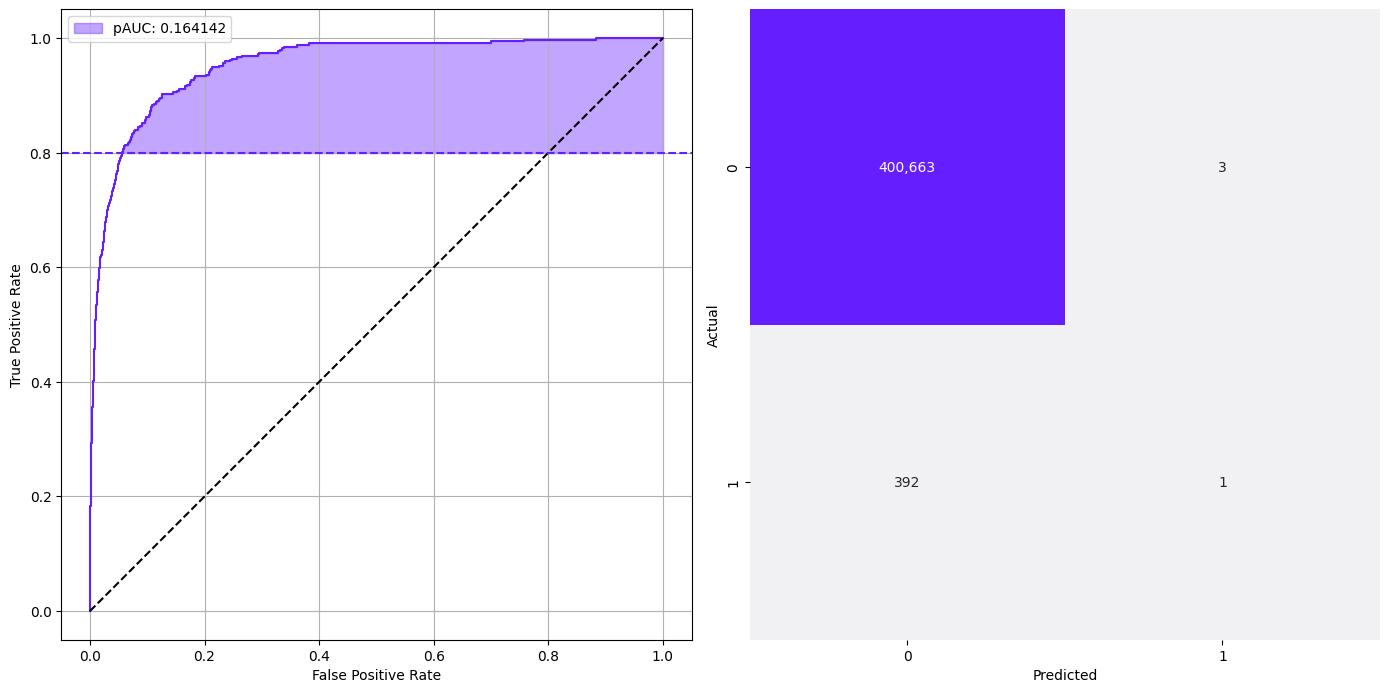

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs['Stacking'][:, 1])
axes[0].plot(fpr, tpr, color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].fill_between(fpr, tpr, 0.8, where=(tpr >= 0.8), color='#651FFF', alpha=0.4, label=f'pAUC: {np.mean(stacking_scores):.6f}')
axes[0].axhline(y=0.8, color='#651FFF', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs['Stacking'].argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt=',', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

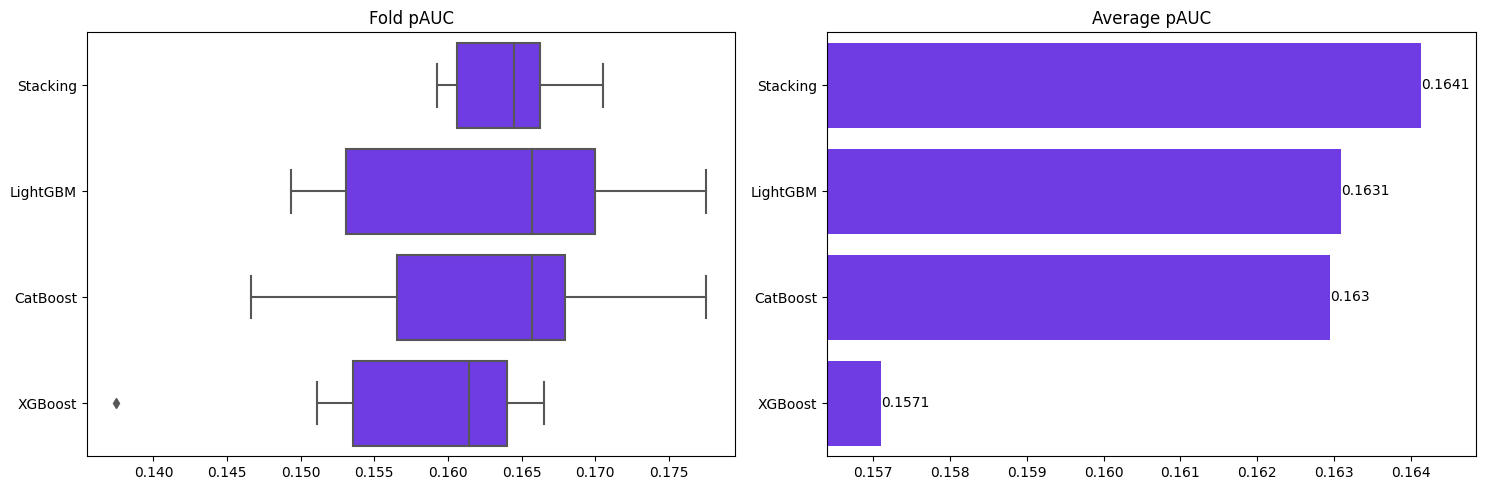

In [30]:
paucs = pd.DataFrame(paucs)
mean_paucs = paucs.mean().sort_values(ascending=False)
order = paucs.mean().sort_values(ascending=False).index.tolist()

min_pauc = mean_paucs.min()
max_pauc = mean_paucs.max()
padding = (max_pauc - min_pauc) * 0.1
lower_limit = min_pauc - padding
upper_limit = max_pauc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=paucs, order=order, ax=axs[0], orient='h', color='#651FFF')
axs[0].set_title('Fold pAUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_paucs.values, y=mean_paucs.index, ax=axs[1], color='#651FFF')
axs[1].set_title('Average pAUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_paucs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

In [31]:
sub = pd.read_csv('/kaggle/input/isic-2024-challenge/sample_submission.csv')
sub['isic_id'] = sub['isic_id']
sub[TARGET] = test_pred_probs['Stacking'][:, 1]
sub.to_csv('submission.csv', index=False)
sub.head()

,isic_id,target
0,ISIC_0015657,0.000150
1,ISIC_0015729,0.000025
2,ISIC_0015740,0.000285


In [32]:
shutil.rmtree('catboost_info')